<a href="https://colab.research.google.com/github/christianadriano/PCA_AquacultureSystem/blob/master/PCA_KMeans_Environment_Carcinicultura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #tables for data wrangling
import numpy as np #basic statistical methods 
import io #for uploading data

#Manual option
from google.colab import files
uploaded = files.upload() #choose file dados_relativizados_carcinicultura.csv



Saving dados_relativizados_centralizados_carcinicultura.csv to dados_relativizados_centralizados_carcinicultura.csv


In [ ]:
#Upload data from cvs file
df = pd.read_csv(io.StringIO(uploaded['dados_relativizados_centralizados_carcinicultura.csv'].decode('utf-8'))) 
print(df)

In [ ]:
column_names = df.columns
#Select fatores Ambientais 
feature_names = [name for name in column_names if name.startswith("A")] 

#feature_names = list(df.columns["A2_DA":"A4_EUC"])
#print(feature_names)
list_names = ['cultivo'] + feature_names
df_cultivo = df[list_names]
df_cultivo.head()



In [ ]:
#Look at correlations 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_cultivo.corr()

# using a styled panda's dataframe from https://stackoverflow.com/a/42323184/1215012
cmap = 'coolwarm'

def magnify():
    return [dict(selector="th", props=[("font-size", "7pt")]),
            dict(selector="td", props=[('padding', "0em 0em")]),
            dict(selector="th:hover", props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover", 
                 props=[('max-width', '200px'), ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())



In [ ]:
#smaller chart
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='coolwarm')

In [ ]:
#check which ones are statiscally significant
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

p_values = calculate_pvalues(df_cultivo)


In [ ]:
#Plot p-values
def highlight_significant(val):
    '''
    highlight in blue only the statistically significant cells
    '''
    color = 'blue' if val < 0.05 else 'grey'
    return 'color: %s' % color

p_values.style.applymap(highlight_significant)

,A2_DA,A3_UE,A5_UN,A6_UF,A7_EUE,A8_EUN,A9_EUF,A11_PEPN,A12_PPO,A19_AF,A20_AMO,A22_REC,A1_PRC,A2_PRN,A3_PRF,A4_EUC
A2_DA,0.000000,0.238700,0.335900,0.054200,0.669000,0.783800,0.976300,0.015900,0.167800,0.465700,0.001300,0.632600,0.474600,0.643900,0.113200,0.517000
A3_UE,0.238700,0.000000,0.013900,0.085700,0.551700,0.338900,0.030500,0.064000,0.772800,0.398600,0.152400,0.647800,0.431100,0.545800,0.703300,0.814600
A5_UN,0.335900,0.013900,0.000000,0.337500,0.437500,0.333300,0.329500,0.272100,0.882300,0.625200,0.677100,0.797500,0.913000,0.511300,0.758500,0.301200
A6_UF,0.054200,0.085700,0.337500,0.000000,0.225800,0.221500,0.498600,0.073900,0.665000,0.282500,0.104100,0.700500,0.421000,0.457400,0.236400,0.117700
A7_EUE,0.669000,0.551700,0.437500,0.225800,0.000000,0.645600,0.054000,0.467800,0.139600,0.797100,0.797800,0.749800,0.483400,0.660100,0.537500,0.000000
A8_EUN,0.783800,0.338900,0.333300,0.221500,0.645600,0.000000,0.031000,0.904900,0.609900,0.211900,0.691500,0.004400,0.002900,0.013200,0.021900,0.093800
A9_EUF,0.976300,0.030500,0.329500,0.498600,0.054000,0.031000,0.000000,0.421800,0.267400,0.787200,0.747100,0.035200,0.021100,0.129800,0.114200,0.409400
A11_PEPN,0.015900,0.064000,0.272100,0.073900,0.467800,0.904900,0.421800,0.000000,0.081400,0.006800,0.014100,0.682700,0.196200,0.964400,0.196500,0.860800
A12_PPO,0.167800,0.772800,0.882300,0.665000,0.139600,0.609900,0.267400,0.081400,0.000000,0.361600,0.057300,0.105600,0.007600,0.189800,0.036700,0.591600
A19_AF,0.465700,0.398600,0.625200,0.282500,0.797100,0.211900,0.787200,0.006800,0.361600,0.000000,0.051800,0.952200,0.950900,0.394400,0.961600,0.828900


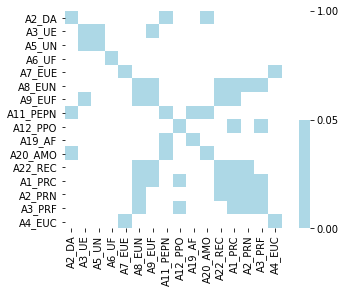

In [ ]:
#Smaller plot of p-values
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

np.random.seed(101)
zvals = np.random.rand(100, 100) * 10

# make a color map of fixed colors
cmap_discrete = colors.ListedColormap(['lightblue', 'white'])
bounds=[0,0.05,1]
norm_binary = colors.BoundaryNorm(bounds, cmap_discrete.N)

# tell imshow about color map so that only set colors are used
img = plt.imshow(zvals, interpolation='nearest', origin='lower',
                    cmap=cmap_discrete, norm=norm_binary)

sns.heatmap(p_values, xticklabels=p_values.columns, yticklabels=p_values.columns, cmap=cmap_discrete, norm=norm_binary)

**PCA** 
Now we do the PCA 

In [ ]:
#Normalize the data to have MEAN==0
from sklearn.preprocessing import StandardScaler

x = df_cultivo.iloc[:,1:].values
x = StandardScaler().fit_transform(x) # normalizing the features
#print(x)


In [ ]:
#Run PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
finalDf = pd.concat([principalDf, df_cultivo[['cultivo']]], axis = 1)

['M. rosenbergii - Espirito Santo-'
 'P. vannamei - Sergipe - Semi intensivo' 'L. vannamei - Aquafort'
 'L. vannamei - Northern' 'L. vannamei - Aquacrusta' 'L. vannamei - HM'
 'L. vannamei - Ilha' 'L. vannamei - Carpixe' 'L. vannamei - Marinus'
 'L. vannamei - Aquabrasilis' 'L. vannamei - Aquarium - baixa densid.'
 'L. vannamei - Aquarium - alta densis'
 'L. vannamei - Aquarium-  bifasico']


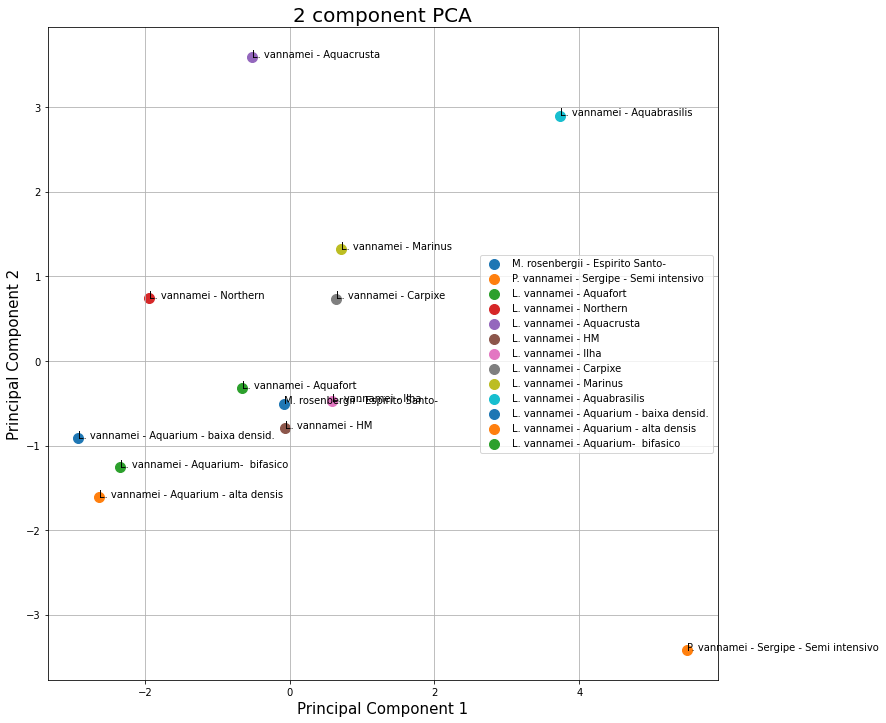

In [ ]:
#Visualize results of PCA in Two Dimensions
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()
print(targets)
for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    ax.scatter(x,y,s = 100)
    ax.annotate(target, (x,y))

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [ ]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))


variance explained by each component: [0.34023213 0.20209521 0.17123726]
total variance explained: 0.7135646001608547


In [ ]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1])}, columns=['cultivo', 'pc1','pc2'])
#df_clustering

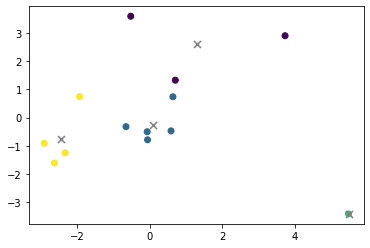

In [ ]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker='x', color="grey"); # Show the 

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
0,M. rosenbergii - Espirito Santo-,-0.073283,-0.505583,0
2,L. vannamei - Aquafort,-0.658878,-0.324169,0
5,L. vannamei - HM,-0.062581,-0.790625,0
6,L. vannamei - Ilha,0.586027,-0.473180,0
7,L. vannamei - Carpixe,0.638037,0.735266,0
8,L. vannamei - Marinus,0.703847,1.322552,0
1,P. vannamei - Sergipe - Semi intensivo,5.490187,-3.418254,1
4,L. vannamei - Aquacrusta,-0.526917,3.590510,2
9,L. vannamei - Aquabrasilis,3.736575,2.899674,2
3,L. vannamei - Northern,-1.941160,0.741077,3


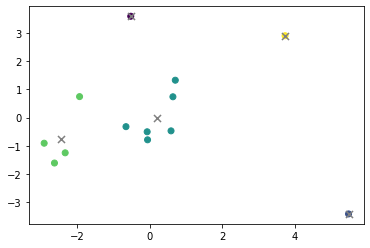

In [ ]:
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50,  marker='x', color="grey"); # Show the 


In my view, we have two large clusters and three outliers, as the graph above shows.

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
7,L. vannamei - Carpixe,0.638037,0.735266,0
8,L. vannamei - Marinus,0.703847,1.322552,0
3,L. vannamei - Northern,-1.941160,0.741077,1
10,L. vannamei - Aquarium - baixa densid.,-2.919138,-0.911388,1
11,L. vannamei - Aquarium - alta densis,-2.634247,-1.614001,1
12,L. vannamei - Aquarium- bifasico,-2.338471,-1.251879,1
1,P. vannamei - Sergipe - Semi intensivo,5.490187,-3.418254,2
9,L. vannamei - Aquabrasilis,3.736575,2.899674,3
4,L. vannamei - Aquacrusta,-0.526917,3.590510,4
0,M. rosenbergii - Espirito Santo-,-0.073283,-0.505583,5


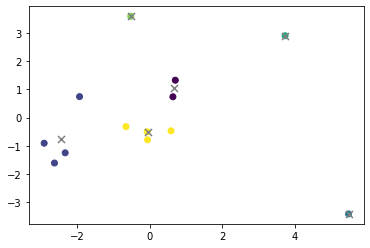

In [ ]:
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:3])
#print(model.cluster_centers_)

#Plot clusters
plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, marker='x', color="grey"); # Show the 

#7 clusters

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,cluster
7,L. vannamei - Carpixe,0.638037,0.735266,0
8,L. vannamei - Marinus,0.703847,1.322552,0
3,L. vannamei - Northern,-1.941160,0.741077,1
10,L. vannamei - Aquarium - baixa densid.,-2.919138,-0.911388,1
11,L. vannamei - Aquarium - alta densis,-2.634247,-1.614001,1
12,L. vannamei - Aquarium- bifasico,-2.338471,-1.251879,1
1,P. vannamei - Sergipe - Semi intensivo,5.490187,-3.418254,2
9,L. vannamei - Aquabrasilis,3.736575,2.899674,3
4,L. vannamei - Aquacrusta,-0.526917,3.590510,4
0,M. rosenbergii - Espirito Santo-,-0.073283,-0.505583,5


In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

Now we analyze 3 Principal Components



In [ ]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]), 'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])}, columns=['cultivo', 'pc1','pc2','pc3'])
#df_clustering

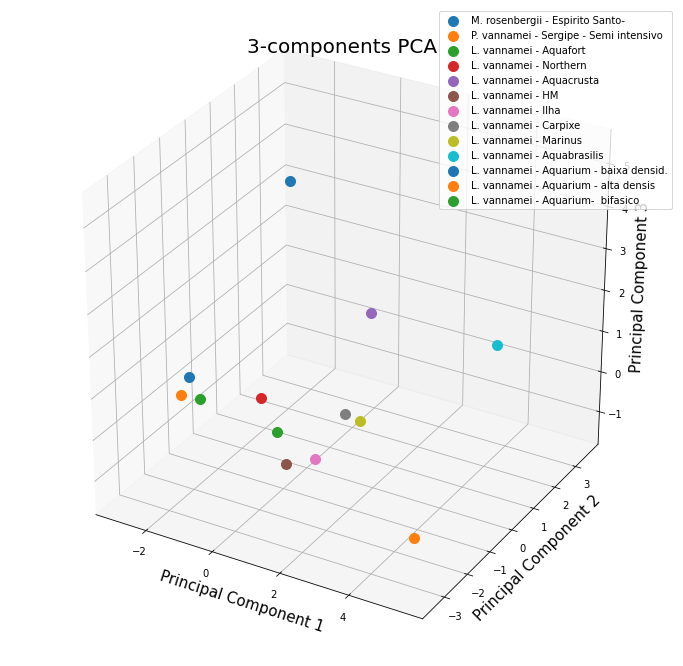

In [ ]:
#Visualize results of PCA in Three Dimensions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    
ax.legend(targets)
ax.grid()

Now we search for clusters for 3 principal components

In [ ]:
variance_list =pca.explained_variance_ratio_
print("variance explained by each component:", variance_list)
print("total variance explained:", sum(variance_list))

In [ ]:
#principal components for each indicador
#print(principalComponents)
#print(targets)
df_clustering = pd.DataFrame({'cultivo': targets,  'pc1':list(principalComponents[:,0]),
                              'pc2': list(principalComponents[:,1]),'pc3': list(principalComponents[:,2])},
                              columns=['cultivo', 'pc1','pc2','pc3'])
#df_clustering

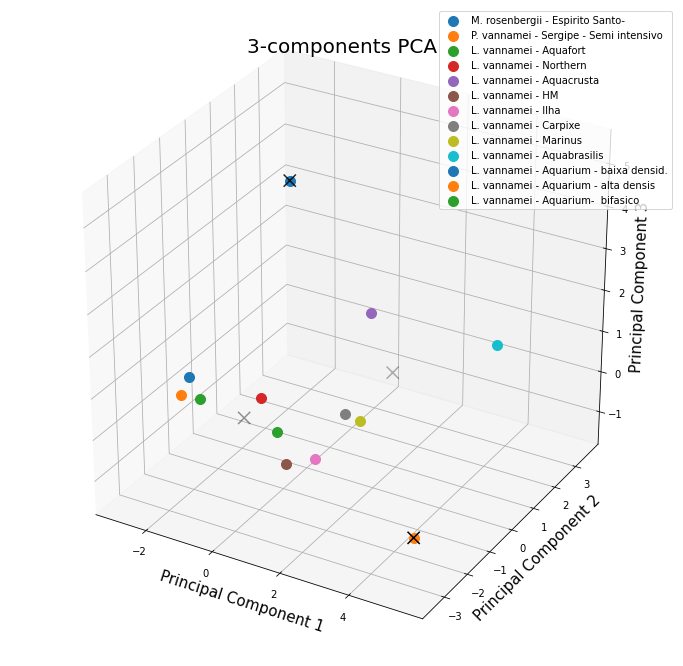

In [ ]:
#Find clusters 
from sklearn.cluster import KMeans
#4 clusters
model = KMeans(4)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')


,cultivo,pc1,pc2,pc3,cluster
2,L. vannamei - Aquafort,-0.658878,-0.324169,-0.928993,0
3,L. vannamei - Northern,-1.941160,0.741077,-0.919455,0
5,L. vannamei - HM,-0.062581,-0.790625,-1.336319,0
6,L. vannamei - Ilha,0.586027,-0.473180,-1.205695,0
10,L. vannamei - Aquarium - baixa densid.,-2.919138,-0.911388,0.205219,0
11,L. vannamei - Aquarium - alta densis,-2.634247,-1.614001,0.161283,0
12,L. vannamei - Aquarium- bifasico,-2.338471,-1.251879,-0.048700,0
0,M. rosenbergii - Espirito Santo-,-0.073283,-0.505583,5.312367,1
4,L. vannamei - Aquacrusta,-0.526917,3.590510,0.192890,2
7,L. vannamei - Carpixe,0.638037,0.735266,-0.680412,2


Comparing k-means of PC12 with PC123, we see that the cluster membership changes completely.

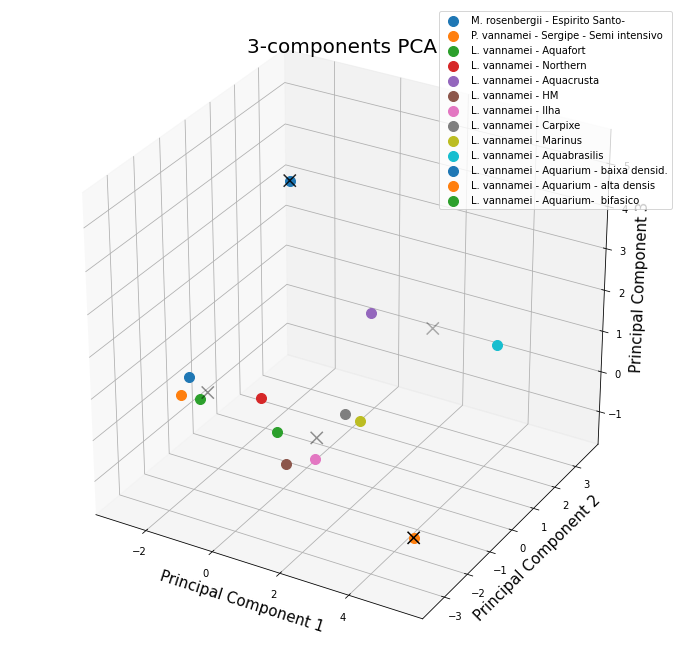

In [ ]:
#Find clusters 
from sklearn.cluster import KMeans
#5 clusters
model = KMeans(5)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
3,L. vannamei - Northern,-1.941160,0.741077,-0.919455,0
10,L. vannamei - Aquarium - baixa densid.,-2.919138,-0.911388,0.205219,0
11,L. vannamei - Aquarium - alta densis,-2.634247,-1.614001,0.161283,0
12,L. vannamei - Aquarium- bifasico,-2.338471,-1.251879,-0.048700,0
4,L. vannamei - Aquacrusta,-0.526917,3.590510,0.192890,1
9,L. vannamei - Aquabrasilis,3.736575,2.899674,0.701351,1
2,L. vannamei - Aquafort,-0.658878,-0.324169,-0.928993,2
5,L. vannamei - HM,-0.062581,-0.790625,-1.336319,2
6,L. vannamei - Ilha,0.586027,-0.473180,-1.205695,2
7,L. vannamei - Carpixe,0.638037,0.735266,-0.680412,2


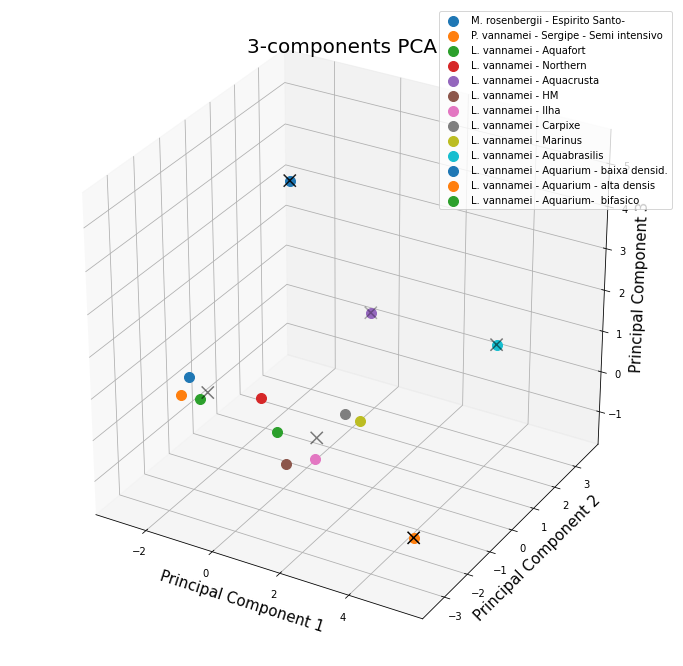

In [ ]:
#Find clusters 
from sklearn.cluster import KMeans
#6 clusters
model = KMeans(6)
model.fit(df_clustering.iloc[:,1:4])
#print(model.cluster_centers_)

#Plot clusters
#plt.scatter(df_clustering.iloc[:,1],df_clustering.iloc[:,2], c=model.labels_.astype(float));
#plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], s=50, color="red"); # Show the 

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3-components PCA', fontsize = 20)
targets = df_cultivo['cultivo'].to_numpy()

for target in targets:
    indicesToKeep = finalDf['cultivo'] == target
    x = finalDf.loc[indicesToKeep, 'principal component 1']
    y = finalDf.loc[indicesToKeep, 'principal component 2']
    z = finalDf.loc[indicesToKeep, 'principal component 3']
    ax.scatter(x,y,z,s = 100)
    #ax.annotate(target, (x,y))

ax.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1],model.cluster_centers_[:,2], s=150, marker='x', color="black"); # Show the 

#for name in targets:  
    
ax.legend(targets)
ax.grid()

In [ ]:
#To which cluster each point belongs?
df1= df_clustering.assign(cluster=pd.Series(model.labels_).values)
df1.sort_values(by='cluster')

,cultivo,pc1,pc2,pc3,cluster
3,L. vannamei - Northern,-1.941160,0.741077,-0.919455,0
10,L. vannamei - Aquarium - baixa densid.,-2.919138,-0.911388,0.205219,0
11,L. vannamei - Aquarium - alta densis,-2.634247,-1.614001,0.161283,0
12,L. vannamei - Aquarium- bifasico,-2.338471,-1.251879,-0.048700,0
9,L. vannamei - Aquabrasilis,3.736575,2.899674,0.701351,1
2,L. vannamei - Aquafort,-0.658878,-0.324169,-0.928993,2
5,L. vannamei - HM,-0.062581,-0.790625,-1.336319,2
6,L. vannamei - Ilha,0.586027,-0.473180,-1.205695,2
7,L. vannamei - Carpixe,0.638037,0.735266,-0.680412,2
8,L. vannamei - Marinus,0.703847,1.322552,-1.132533,2
